# 1.Install and Import Dependencies

In [1]:
!pip list

Package                    Version
-------------------------- ---------------
absl-py                    1.4.0
ale-py                     0.8.1
anyio                      4.2.0
archspec                   0.2.1
argon2-cffi                21.3.0
argon2-cffi-bindings       21.2.0
asttokens                  2.0.5
async-lru                  2.0.4
attrs                      23.1.0
AutoROM                    0.6.1
AutoROM.accept-rom-license 0.6.1
Babel                      2.11.0
backcall                   0.2.0
beautifulsoup4             4.12.2
bleach                     4.1.0
boltons                    23.0.0
Bottleneck                 1.3.5
cachetools                 5.3.2
certifi                    2024.2.2
cffi                       1.16.0
charset-normalizer         2.0.4
click                      8.1.7
cloudpickle                2.2.1
colorama                   0.4.6
comm                       0.1.2
conda                      24.1.0
conda-libmamba-solver      24.1.0
conda-package-handl

In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [4]:
!pip install mss pydirectinput pytesseract

In [5]:
# MSS used for screen
from mss import mss
# sendung commands
import pydirectinput
# OCR for game over extraction
import pytesseract
# opencv allows us to do frame processing
import cv2
# trasformational framework
import numpy as np
# visualize captured frames
import matplotlib.pyplot as plt
# bring in time pauses
import time
# environment components
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
# random
import random
# pytorch
import torch

# 2.Bulid the Environment

### 2.1 Create environment 

In [6]:
class WebGame(Env):
    # set up enviroment action and observation shapes
    def __init__(self):
        # subclass model
        super().__init__()
        # setup space
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # define extraction parameter for the game
        self.cap = mss()
        self.game_location = {'top':300, 'left':0, 'width':600, 'height':500}
        self.done_location = {'top':405, 'left':630, 'width':660, 'height':70}
        self.seed_value = None

    #what is called to do somthing in the game
    def step(self, action):
        # action key- 0=space, 1= duck(down), 2= no action(no operations)
        action_map = {
            0:'space',
            1:'done',
            2:'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])
        # checking whether the game is done
        done, done_cap = self.get_done()
        # get the next observation
        new_observation = self.get_observation()
        # reward - we get a point for every frame we're alive
        reward = 1
        # truncated signal
        truncated = False
        # info dictionary 
        info = {}
        return new_observation, reward, done, truncated, info

    # visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
        
        pass

     # restart the game
    def reset(self, **Kwargs):
        seed = Kwargs.get('seed',None)
        self.seed_values = seed

        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)
            
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        
        return self.get_observation(),{}

    def seed(self, seed=None):
        self.seed_value = seed
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)
            # Additional seed-related initialization code specific to your environmen

    # this class down the observation
    def close(self):
        cv2.destroyAllWindows()

    # get the part of the observation of the game that we want
    def get_observation(self):
        # get screen capture of game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # resized
        resized = cv2.resize(gray,(100,83))
        # add channels first
        channel = np.reshape(resized,(1,83,100))
        return channel

    #get the done text using OCR
    def get_done(self):
        # get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # valid done text
        done_strings = ['GAME','GAHE']

        # apply ocr
        done = False
        pytesseract.pytesseract.tesseract_cmd = r'C:\Users\np585\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
            
        return done, done_cap
            

In [7]:
env = WebGame()

In [8]:
env.render()

In [9]:
env.close()

In [10]:
env.seed(42)

In [11]:
env.reset()

(array([[[245, 255, 255, ..., 255, 255, 255],
         [245, 255, 255, ..., 255, 255, 255],
         [245, 255, 255, ..., 255, 245, 255],
         ...,
         [245, 255, 255, ..., 255, 255, 255],
         [245, 255, 255, ..., 255, 255, 255],
         [245, 255, 255, ..., 255, 255, 255]]], dtype=uint8),
 {})

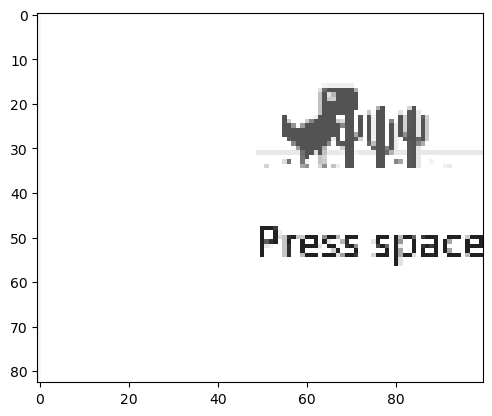

In [13]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [14]:
done, done_cap = env.get_done()

In [15]:
done

False

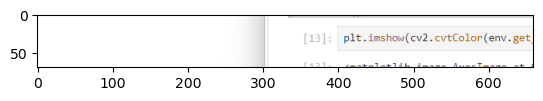

In [16]:
plt.imshow(done_cap)

### 2.2 Test Environment

In [17]:
env= WebGame()

In [18]:
obs = env.get_observation()

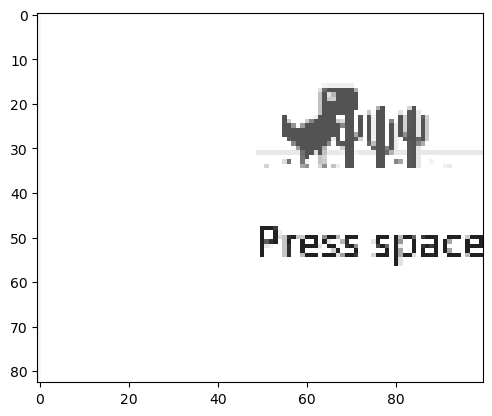

In [19]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

In [20]:
done, done_cap = env.get_done()
print(done)

False


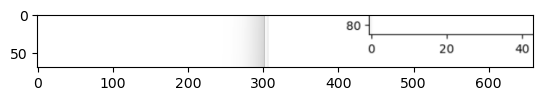

In [21]:
plt.imshow(done_cap)

In [22]:
pytesseract.image_to_string(done_cap)[:4]

'804\n'

In [23]:
# play 10 games
for episode in range(10): 
    obs = env.reset()
    done = False
    total_reward = 0
    try: 
        while not done:
            # sample an action 
            action = env.action_space.sample()
            # take a tsep in the environment
            step_result = env.step(action)
            obs, reward, done, info = step_result[:-1]# ignore the last value(truncated)
            total_reward +=reward
            print(f'Total reward for episode {episode} is {total_reward}') 
    except  KeyboardInterrupt:
        print(f'Training interrupted by the user during episode {episode}.')
        break  # Exit the loop if interrupte   

Total reward for episode 0 is 1
Total reward for episode 0 is 2
Total reward for episode 0 is 3
Total reward for episode 0 is 4
Total reward for episode 0 is 5
Total reward for episode 0 is 6
Total reward for episode 0 is 7
Total reward for episode 0 is 8
Total reward for episode 0 is 9
Total reward for episode 0 is 10
Total reward for episode 0 is 11
Total reward for episode 0 is 12
Total reward for episode 0 is 13
Total reward for episode 0 is 14
Total reward for episode 0 is 15
Total reward for episode 0 is 16
Total reward for episode 0 is 17
Total reward for episode 0 is 18
Total reward for episode 0 is 19
Total reward for episode 0 is 20
Total reward for episode 0 is 21
Total reward for episode 0 is 22
Total reward for episode 0 is 23
Total reward for episode 0 is 24
Total reward for episode 0 is 25
Total reward for episode 0 is 26
Total reward for episode 0 is 27
Total reward for episode 0 is 28
Total reward for episode 0 is 29
Total reward for episode 0 is 30
Total reward for ep

# 3. Train the Model

### 3.1 Create Callback

In [24]:
# import os
import os
# import base callback for saving  models 
from stable_baselines3.common.callbacks import BaseCallback
# check environment   
from stable_baselines3.common import env_checker

In [25]:
# check the enviroment is ok
env_checker.check_env(env)

In [26]:
class TrainandLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainandLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [27]:
CHECKPOINT_DIR='./train/'
LOG_DIR = './logs/'

In [28]:
callback = TrainandLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

### 3.2 Bulid DQN and Train

In [29]:
# import DQN alogorithm
from stable_baselines3 import DQN

In [30]:
# create model
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1,
           buffer_size=9000,learning_starts=0)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [31]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [32]:
#kick off training
writer = model.learn(total_timesteps=1000, callback=callback)

Logging to ./logs/DQN_3


KeyboardInterrupt: 

# 4.Test out Model

In [49]:
# play 10 games
for episode in range(10): 
    obs = env.reset()
    done = False
    total_reward = 0
    try: 
        while not done:
            # sample an action 
            action = env.action_space.sample()
            # take a tsep in the environment
            step_result = env.step(int(action))
            obs, reward, done, info = step_result[:-1]# ignore the last value(truncated)
            total_reward +=reward
            print(f'Total reward for episode {episode} is {total_reward}') 
    except  KeyboardInterrupt:
        print(f'Training interrupted by the user during episode {episode}.')
        break  # Exit the loop if interrupte   

Total reward for episode 0 is 1
Total reward for episode 0 is 2
Total reward for episode 0 is 3
Total reward for episode 0 is 4
Total reward for episode 0 is 5
Total reward for episode 0 is 6
Total reward for episode 0 is 7
Total reward for episode 0 is 8
Total reward for episode 0 is 9
Total reward for episode 0 is 10
Total reward for episode 0 is 11
Total reward for episode 0 is 12
Total reward for episode 0 is 13
Total reward for episode 0 is 14
Total reward for episode 0 is 15
Total reward for episode 0 is 16
Total reward for episode 0 is 17
Total reward for episode 0 is 18
Total reward for episode 0 is 19
Total reward for episode 0 is 20
Total reward for episode 0 is 21
Total reward for episode 0 is 22
Total reward for episode 0 is 23
Total reward for episode 0 is 24
Total reward for episode 0 is 25
Total reward for episode 0 is 26
Total reward for episode 0 is 27
Total reward for episode 0 is 28
Total reward for episode 0 is 29
Total reward for episode 0 is 30
Total reward for ep